# SemanticDraw Region-Based Semantic Control Demo



## Preparation

In [1]:
seed = 2024
device = 0

In [2]:
import sys
import time
import warnings

sys.path.append('../src')
warnings.filterwarnings('ignore')

import torch
import torchvision.transforms as T
from PIL import Image
from diffusers.utils import make_image_grid
from functools import reduce

from util import seed_everything, blend
from model import SemanticDrawPipeline
from ipython_util import dispt


seed_everything(seed)
device = f'cuda:{device}'
print(f'[INFO] Initialized with seed  : {seed}')
print(f'[INFO] Initialized with device: {device}')

[INFO] Initialized with seed  : 2024
[INFO] Initialized with device: cuda:0


# Run

## Step 1: Load a SemanticDraw pipeline.

In [3]:
smd = SemanticDrawPipeline(
    device,
    hf_key='ironjr/BlazingDriveV11m',
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


[INFO] Loading Stable Diffusion...
[INFO] Using custom model key: ironjr/BlazingDriveV11m


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]
unet/diffusion_pytorch_model.safetensors not found
Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:00,  5.99it/s]An error occurred while trying to fetch /home/alchemist/.cache/huggingface/hub/models--ironjr--BlazingDriveV11m/snapshots/2e3e7ce26c6730c87863b9d838ddd3de652eb040/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/alchemist/.cache/huggingface/hub/models--ironjr--BlazingDriveV11m/snapshots/2e3e7ce26c6730c87863b9d838ddd3de652eb040/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  71%|███████▏  | 5/7 [00:01<00:00,  3.34it/s]An error occurred while trying to fetch /home/alchemist/.cache/huggingface/hub/models--ironjr--BlazingDriveV11m/snapshots/2e3e7ce26c6730c87863b9d838ddd3de652eb040/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/alchemist/.c

[INFO] Model is loaded!


## Step 2: Load *semantic palette*, i.e., prompts and masks.

[INFO] Loading masks...


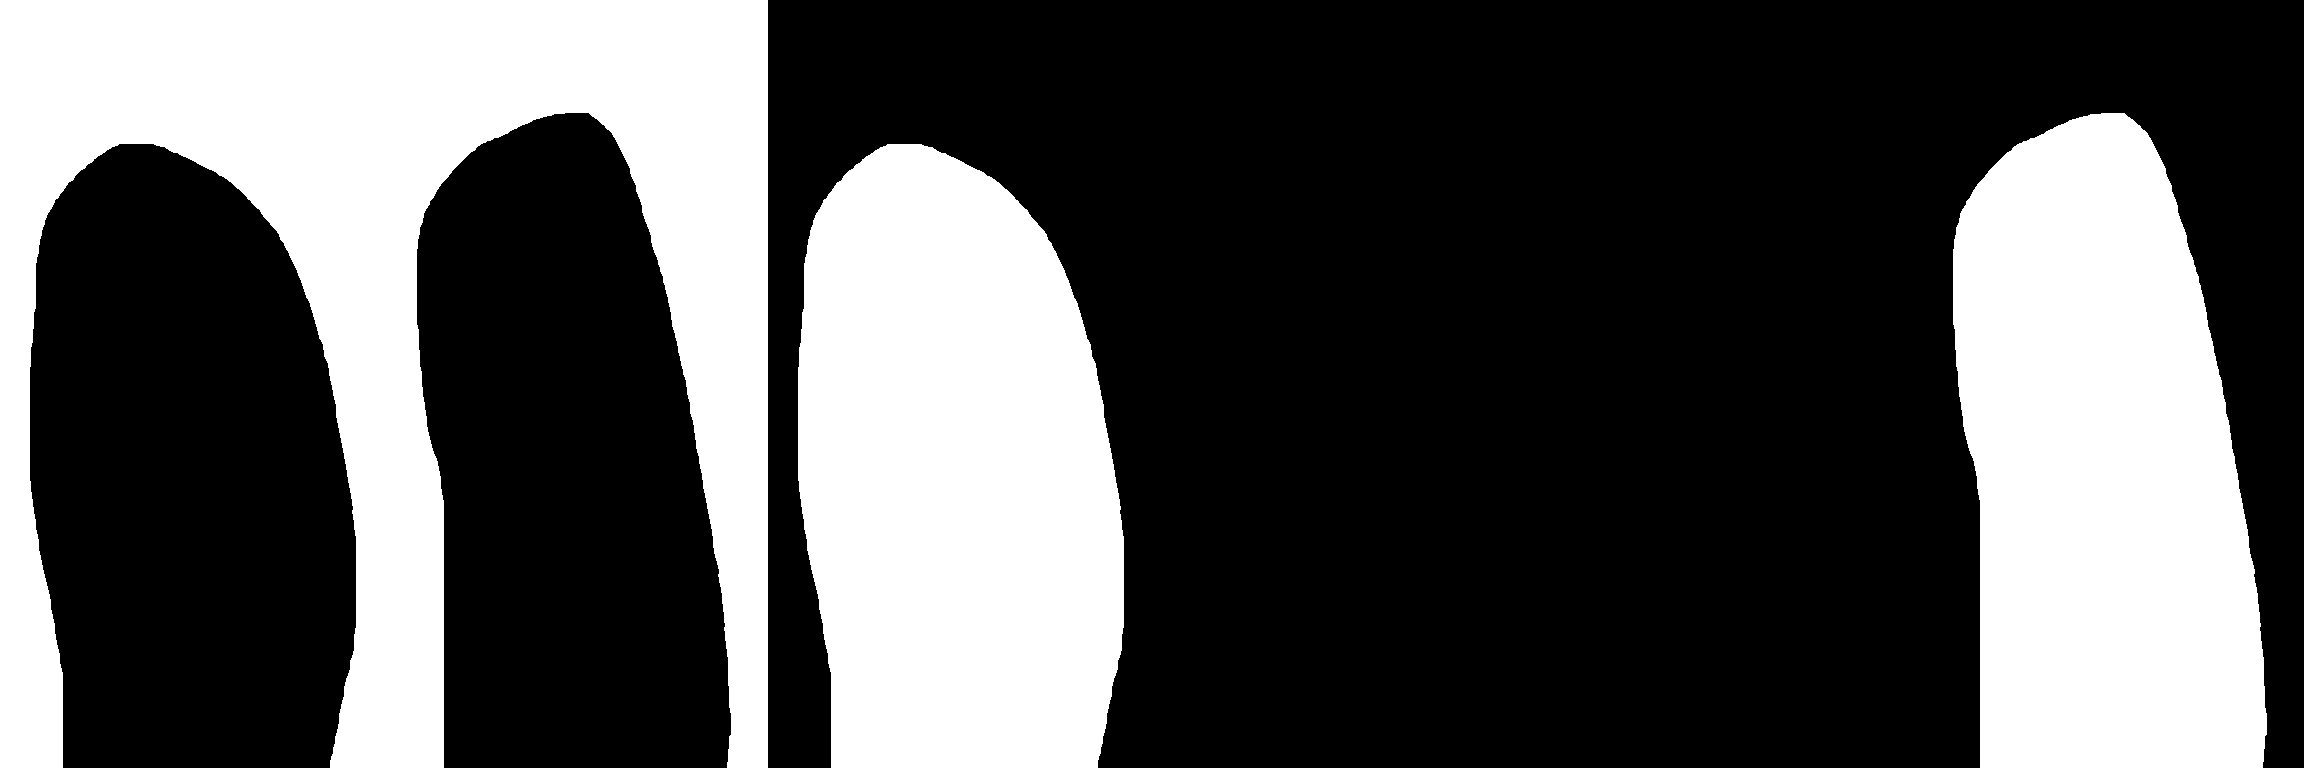

[INFO] Loading prompts...
Background Prompt: 1girl, 1boy, times square
Prompt1: 1boy, looking at viewer, brown hair, casual shirt
Prompt2: 1girl, looking at viewer, pink hair, leather jacket
Background Negative Prompt: worst quality, bad quality, normal quality, cropped, framed, 
Negative Prompt1: worst quality, bad quality, normal quality, cropped, framed, 1girl
Negative Prompt2: worst quality, bad quality, normal quality, cropped, framed, 1boy


In [4]:
# Prepare masks.
print('[INFO] Loading masks...')

name = 'timessquare'
mask_all = Image.open(f'../assets/{name}/{name}_full.png').convert('RGBA')
masks = [Image.open(f'../assets/{name}/{name}_{i}.png').convert('RGBA') for i in range(1, 3)]
masks = [(T.ToTensor()(mask)[-1:] > 0.5).float() for mask in masks]
# Background is simply non-marked set of pixels.
background = reduce(torch.logical_and, [m == 0 for m in masks])
dispt([background] + masks, row=1)

masks = torch.stack([background] + masks, dim=0)
mask_strengths = 1.0
mask_stds = 0.0

# Prepare prompts.
print('[INFO] Loading prompts...')

prompts = [
    # Background prompt.
    '1girl, 1boy, times square',
    # Foreground prompts.
    '1boy, looking at viewer, brown hair, casual shirt',
    '1girl, looking at viewer, pink hair, leather jacket',
]
negative_prompts = [
    '',
    '1girl',
    '1boy',
]
negative_prompt_prefix = 'worst quality, bad quality, normal quality, cropped, framed'
negative_prompts = [negative_prompt_prefix + ', ' + p for p in negative_prompts]

for i, prompt in enumerate(prompts):
    print((f'Prompt{i}' if i > 0 else 'Background Prompt') + ': ' + prompt)
for i, prompt in enumerate(negative_prompts):
    print((f'Negative Prompt{i}' if i > 0 else 'Background Negative Prompt') + ': ' + prompt)

height, width = masks.shape[-2:]

## Step 3: Generate images from multiple text prompts in 10 seconds!

100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Elapsed Time: 5.9077136516571045


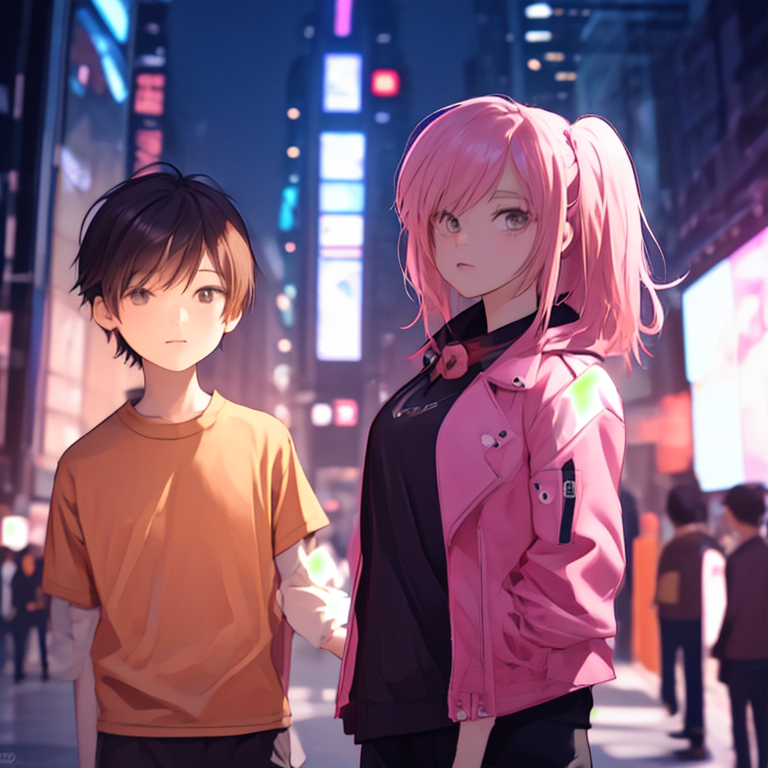

In [5]:
tic = time.time()
img = smd(
    prompts, negative_prompts, masks=masks.float(),
    mask_stds=mask_stds, mask_strengths=mask_strengths,
    height=height, width=width, bootstrap_steps=2,
)
toc = time.time()
print(f'Elapsed Time: {toc - tic}')
display(img)